In [ ]:
import os

if not os.path.exists('MLPTTS'):

  %matplotlib inline
  !pip install tqdm -q
  !pip install gdown
  !pip install -q tacotron

  import sys
  import time
  import matplotlib
  import matplotlib.pylab as plt
  import gdown
  import IPython.display as ipd
  import numpy as np
  import torch
  import json
  from IPython.display import clear_output
  from os.path import exists, join, basename, splitext
  from tqdm.notebook import tqdm

  git_repo_url = 'https://github.com/Yabko2305/taco2_diploma_ukr.git'
  project_name = splitext(basename(git_repo_url))[0]

  !git clone -q --recursive {git_repo_url}
  !git clone -q --recursive https://github.com/SortAnon/hifi-gan
  !pip install -q librosa unidecode

  sys.path.append('hifi-gan')
  sys.path.append(project_name)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.4/910.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from collections import namedtuple
from text.symbols import symbols

def get_hparams(**kwargs):
    return namedtuple('GenericDict', kwargs.keys())(**kwargs)

def create_hparams(hparams_string=None, verbose=False):
    """Create model hyperparameters. Parse nondefault from given string."""

    hparams = get_hparams(
        ################################
        # Experiment Parameters        #
        ################################
        iters_per_checkpoint=1000,
        seed=1234,
        dynamic_loss_scaling=True,
        fp16_run=False,
        distributed_run=False,
        dist_backend="nccl",
        dist_url="tcp://localhost:54321",
        cudnn_enabled=True,
        cudnn_benchmark=False,
        ignore_layers=[],

        ################################
        # Data Parameters             #
        ################################
        load_mel_from_disk=True,
        text_cleaners=['ukr_spec_cleaners'],

        ################################
        # Audio Parameters             #
        ################################
        max_wav_value=1578202680.5,
        sampling_rate=22050,
        filter_length=1024,
        hop_length=256,
        win_length=1024,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=8000.0,

        ################################
        # Model Parameters             #
        ################################
        n_symbols=len(symbols),
        symbols_embedding_dim=512,

        # Encoder parameters
        encoder_kernel_size=5,
        encoder_n_convolutions=3,
        encoder_embedding_dim=512,

        # Decoder parameters
        n_frames_per_step=1,  # currently only 1 is supported
        decoder_rnn_dim=1024,
        prenet_dim=256,
        max_decoder_steps=3000,
        gate_threshold=0.25,

        # Attention parameters
        attention_rnn_dim=1024,
        attention_dim=128,

        # Location Layer parameters
        attention_location_n_filters=32,
        attention_location_kernel_size=31,

        # Mel-post processing network parameters
        postnet_embedding_dim=512,
        postnet_kernel_size=5,
        postnet_n_convolutions=5,

        ################################
        # Optimization Hyperparameters #
        ################################
        use_saved_learning_rate=False,
        learning_rate=1e-3,
        weight_decay=1e-6,
        grad_clip_thresh=1.0,
        mask_padding=True,  # set model's padded outputs to padded values
        training_files = "/content/tacotron2/filelists/train_text.txt",
        validation_files = "/content/tacotron2/filelists/test_text.txt",
        cleaners='transliteration_cleaners',

        batch_size = 40,
        epochs =  50,

        p_attention_dropout=0.1,
        p_decoder_dropout=0.1,
        decay_start = 15000,
        A_ = 5e-4,
        B_ = 8000,
        C_ = 0,
        min_learning_rate = 1e-5,
        show_alignments = True
    )


    if hparams_string:
        tf.logging.info('Parsing command line hparams: %s', hparams_string)
        hparams.parse(hparams_string)

    if verbose:
        tf.logging.info('Final parsed hparams: %s', hparams.values())

    return hparams


/content/taco2_diploma_ukr/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/content/taco2_diploma_ukr/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


In [ ]:
#@title Init all {display-mode: "form"}


from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from env import AttrDict
from meldataset import MAX_WAV_VALUE
from models import Generator
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict

HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

# Setup Pronounciation Dictionary
# thisdict = cmudict.dict()

d = 'https://drive.google.com/uc?id='


graph_width = 900
graph_height = 360

previous_tt2_id = ''
previous_gan = ''


def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
  fig, axes = plt.subplots(1, len(data), figsize=figsize)
  for i in range(len(data)):
      axes[i].imshow(data[i], aspect='auto', origin='lower',
                  interpolation='none', cmap='inferno')
  fig.canvas.draw()
  plt.show()

def get_hifigan(MODEL_ID):
  # Download HiFi-GAN
  hifigan_pretrained_model = 'hifimodel'
  gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)
  if not exists(hifigan_pretrained_model):
      raise Exception("HiFI-GAN model failed to download!")
  # Load HiFi-GAN
  conf = os.path.join("hifi-gan", "config_v1.json")
  with open(conf) as f:
      json_config = json.loads(f.read())
  h = AttrDict(json_config)
  torch.manual_seed(h.seed)
  hifigan = Generator(h).to(torch.device("cuda"))
  state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cuda"))
  hifigan.load_state_dict(state_dict_g["generator"])
  hifigan.eval()
  hifigan.remove_weight_norm()
  print(type(hifigan))
  return hifigan, h


def has_MMI(STATE_DICT):
  return any(True for x in STATE_DICT.keys() if "mi." in x)

def get_Tactron2(MODEL_ID):
  # Download Tacotron2
  tacotron2_pretrained_model = 'MLPTTS'
  gdown.download(d+MODEL_ID, tacotron2_pretrained_model, quiet=False)
  if not exists(tacotron2_pretrained_model):
      raise Exception("Tacotron2 model failed to download!")
  # Load Tacotron2 and Config
  hparams = create_hparams()
  model = Tacotron2(hparams)
  state_dict = torch.load(tacotron2_pretrained_model)['state_dict']
  if has_MMI(state_dict):
      raise Exception("ERROR: This notebook does not currently support MMI models.")
  model.load_state_dict(state_dict)
  _ = model.cuda().eval().half()
  return model, hparams

def get_model_id(name):
  models = {
      'alex 120_8': '1lyo91yhMNQXvt00_5Xel7EwoDc14II7w',
      'ljspeech_1250_100_no_noise': '13UwZynkmCT25E3Vz8z-FvssBtcEqVTAr',
      'ljspeech_1250_100_noised': '1riRPDdShgER0OACPYfP3kBQac11ro1-t',
      'ukrainian_test': '1IhliKdxbsmIBNWU6ysqoIMA8W3MPgcxh',
      'ukrainian_strip': '1nS7MTIVGyPsmCYDVuqYyscs6wTJCZbzg',
      'ukrainian_mykola': '142CoKwwyNJX9aAgVkUQDUThZYx3l_Wg9'
  }
  return models.get(name)

def get_waveglow():
  waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='int16')
  waveglow = waveglow.remove_weightnorm(waveglow)
  waveglow = waveglow.to('cuda')
  waveglow.eval().half()
  return waveglow

def infer(taco_model, sequence, model_type, cleaner_type):
  mel_outputs, mel_outputs_postnet, _, alignments = taco_model.inference(sequence)
  plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
            alignments.float().data.cpu().numpy()[0].T))


  if model_type == 'waveglow':
    y_g_hat = gan.infer(mel_outputs_postnet)
  else:
    y_g_hat = gan(mel_outputs_postnet.float())

  audio = y_g_hat.squeeze()
  audio = audio * MAX_WAV_VALUE
  ipd.display(ipd.Audio(audio.cpu().numpy().astype("int16"), rate=hparams.sampling_rate))

def end_to_end_infer(text, model_type, cleaner_type):
  for i in [x for x in text.split("\n") if len(x)]:

    if i[-1] != ";": i=i+";"

    %matplotlib inline
    with torch.no_grad(): # save VRAM by not including gradients
      sequence = np.array(text_to_sequence(i, [cleaner_type]))[None, :]
      sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

      infer(model, sequence, model_type, cleaner_type)


clear_output()

Enter/Paste your text.
--------------------------------------------------
Це демонстраційний текст


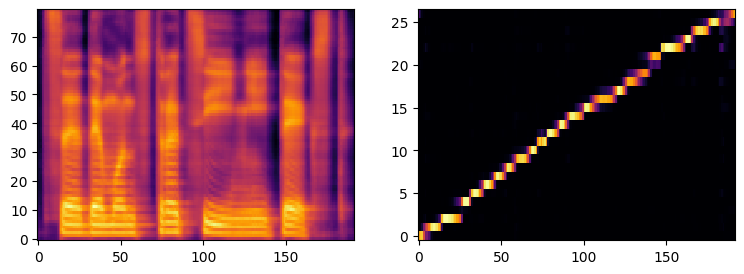

--------------------------------------------------
Stopping...


In [ ]:
#@title If you want to use your own model, insert it's url and check field "use_my_own_model" {display-mode: "form"}

model_url = 'https://drive.google.com/file/d/1gSk9RTLnTyZ7H40Dyfe1a_XXYyn5HU4p/view?usp=sharing' #@param {type:"string"}
use_my_own_model = False #@param {type:"boolean"}
model_name = "ukrainian_mykola"  #@param ['ljspeech_1250_100_no_noise', 'ljspeech_1250_100_noised', 'alex 120_8', 'ukrainian_test', 'ukrainian_strip', 'ukrainian_mykola']
model_type = "hifi-gan" #@param ['waveglow', 'hifi-gan']
cleaner_type = "transliteration_cleaners" #@param ['transliteration_cleaners', 'ukr_spec_cleaners', 'ukr_non_trans_cleaners']
steps = 1000
stop_threshold = 0.27

model_url = model_url.lstrip("https://drive.google.com/file/d/")
model_url = model_url.rstrip("/view?usp=sharing")

if use_my_own_model:
  Tacotron_model = model_url
else:
  Tacotron_model = get_model_id(model_name)

TACOTRON2_ID = Tacotron_model


if model_type == 'waveglow':
  gan = get_waveglow()
else:
  gan, h = get_hifigan(HIFIGAN_ID)

model, hparams = get_Tactron2(Tacotron_model)
model.decoder.max_decoder_steps = steps
model.decoder.gate_threshold = stop_threshold

clear_output()

time.sleep(1)
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        # clear_output()
        if line == "":
            continue
        end_to_end_infer(line, model_type, cleaner_type)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break